In [31]:
# 필요한 PyTorch 라이브러리 불러오기
import torch
import torch.nn as nn
import torchvision.transforms as transforms

In [32]:
# GPU 장치 사용 설정
use_cuda = True
device = torch.device("cuda" if use_cuda else "cpu")

#### **이미지넷(ImageNet)에 정의된 클래스 정보 가져오기**

In [33]:
from urllib.request import urlretrieve
import json

# 이미지넷(ImageNet)에 정의된 1,000개의 레이블(클래스) 정보 가져오기
imagenet_json, _ = urlretrieve('http://www.anishathalye.com/media/2017/07/25/imagenet.json')
with open(imagenet_json) as f:
    imagenet_labels = json.load(f)

In [34]:
# 인덱스(index) 281에 해당하는 클래스는 tabby cat입니다.
# 인덱스(index) 282에 해당하는 클래스는 tiger cat입니다.

print(imagenet_labels[281])
print(imagenet_labels[282])

tabby, tabby cat
tiger cat


#### **이미지 처리 함수 정의 및 이미지 가져와 출력해보기**

In [35]:
imsize = 299

preprocess = transforms.Compose([
    transforms.Resize(imsize), # 이미지의 크기를 변경
    transforms.CenterCrop(imsize), # 이미지의 중앙 부분을 잘라서 크기 조절
    transforms.ToTensor(), # torch.Tensor 형식으로 변경 [0, 255] → [0, 1]
])

In [36]:
# 이미지(그림) 출력 관련 라이브러리
import matplotlib.pyplot as plt
import PIL

In [37]:
# 특정한 경로에서 이미지를 가져와 torch.Tensor로 변환하는 함수
def image_loader(path):
    image = PIL.Image.open(path)
    # 전처리 이후에 네트워크 입력에 들어갈 이미지에 배치 목적의 차원(dimension) 추가
    image = preprocess(image).unsqueeze(0)
    return image.to(device, torch.float) # GPU로 올리기

In [46]:
# 실제로 특정 URL에서 이미지를 불러오기
url = "https://www.litter-robot.com/media/magefan_blog/toyger-cat4_copy.png"
image_path, _ = urlretrieve(url)
image = image_loader(image_path)

In [40]:
# torch.Tensor 형태의 이미지를 화면에 출력하는 함수
def imshow(tensor):
    # matplotlib는 CPU 기반이므로 CPU로 옮기기
    image = tensor.cpu().clone()
    # torch.Tensor에서 사용되는 배치 목적의 차원(dimension) 제거
    image = image.squeeze(0)
    # PIL 객체로 변경 
    image = transforms.ToPILImage()(image)
    # 이미지를 화면에 출력(matplotlib는 [0, 1] 사이의 값이라고 해도 정상적으로 처리)
    plt.imshow(image)

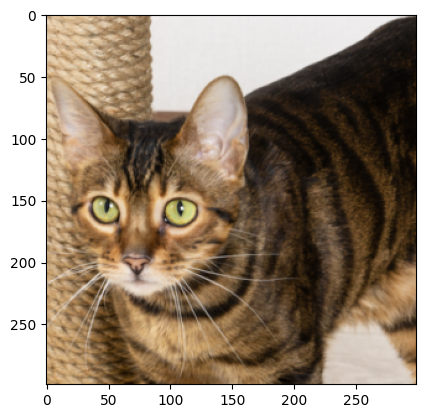

In [47]:
plt.figure()
imshow(image)

#### **사전 학습된(pretrained) 모델을 불러와 사용해보기**

In [42]:
# 입력 데이터 정규화를 위한 클래스 정의
class Normalize(nn.Module) :
    def __init__(self, mean, std) :
        super(Normalize, self).__init__()
        self.register_buffer('mean', torch.Tensor(mean))
        self.register_buffer('std', torch.Tensor(std))
        
    def forward(self, input):
        mean = self.mean.reshape(1, 3, 1, 1)
        std = self.std.reshape(1, 3, 1, 1)
        return (input - mean) / std

In [43]:
# torch.Tensor 형식의 이미지 데이터는 입력 정규화를 거치기 전이므로, 정규화 이후에 모델에 넣도록 설정
model = nn.Sequential(
    # 기본적인 Inception v3와 동일한 동작을 위하여 정규화 레이어 추가
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    torch.hub.load('pytorch/vision:v0.6.0', 'inception_v3', pretrained=True)
).to(device).eval() # 모델을 GPU로 옮기기 및 평가(테스트) 모드로 변경

Downloading: "https://github.com/pytorch/vision/zipball/v0.6.0" to /root/.cache/torch/hub/v0.6.0.zip
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/inception_v3_google-0cc3c7bd.pth" to /root/.cache/torch/hub/checkpoints/inception_v3_google-0cc3c7bd.pth
100%|██████████| 104M/104M [00:03<00:00, 27.6MB/s]


In [48]:
# 기본적인 이미지를 실제 모델에 넣어 결과 확인
outputs = model(image)
# 확률을 계산하기 위해 소프트맥스(softmax) 함수 취하기
percentages = torch.nn.functional.softmax(outputs, dim=1)[0] * 100
# 가장 높은 값을 가지는 5개의 인덱스를 하나씩 확인하며
print("< 가장 높은 확률을 가지는 클래스들 >")
for i in outputs[0].topk(5)[1]:
    # 높은 값을 가지는 순서대로 인덱스에 해당하는 클래스 이름과, 그 확률 값 출력하기
    print(f"인덱스: {i.item()} / 클래스명: {imagenet_labels[i]} / 확률: {round(percentages[i].item(), 4)}%")
round(percentages[281].item(), 4)
round(percentages[282].item(), 4)


< 가장 높은 확률을 가지는 클래스들 >
인덱스: 281 / 클래스명: tabby, tabby cat / 확률: 47.3659%
인덱스: 285 / 클래스명: Egyptian cat / 확률: 44.1585%
인덱스: 282 / 클래스명: tiger cat / 확률: 5.2791%
인덱스: 903 / 클래스명: wig / 확률: 0.072%
인덱스: 515 / 클래스명: cowboy hat, ten-gallon hat / 확률: 0.0423%


5.2791

1. https://www.catster.com/wp-content/uploads/2017/11/Mackerel-Tabby-cat.jpg.webp
인덱스: 281 / 클래스명: tabby, tabby cat / 확률: 73.9605%
인덱스: 282 / 클래스명: tiger cat / 확률: 18.9208%

2. "https://www.thesprucepets.com/thmb/APYdMl_MTqwODmH4dDqaY5q0UoE=/750x0/filters:no_upscale():max_bytes(150000):strip_icc():format(webp)/all-about-tabby-cats-552489-hero-a23a9118af8c477b914a0a1570d4f787.jpg
인덱스: 282 / 클래스명: tiger cat / 확률: 45.7714%
인덱스: 281 / 클래스명: tabby, tabby cat / 확률: 23.4187%

3. https://www.catster.com/wp-content/uploads/2017/09/A-tabby-cat-with-an-ID-collar-on.jpg.webp
인덱스: 281 / 클래스명: tabby, tabby cat / 확률: 79.9398%
인덱스: 282 / 클래스명: tiger cat / 확률: 12.146%

4. https://dinoanimals.com/wp-content/uploads/2016/09/Tabby-cat-1.jpg
인덱스: 281 / 클래스명: tabby, tabby cat / 확률: 71.9203%
인덱스: 282 / 클래스명: tiger cat / 확률: 11.504%

5. https://dinoanimals.com/wp-content/uploads/2016/09/Tabby-cat-2.jpg
인덱스: 281 / 클래스명: tabby, tabby cat / 확률: 63.1601%
인덱스: 282 / 클래스명: tiger cat / 확률: 31.9501%

6. https://dinoanimals.com/wp-content/uploads/2016/09/Tabby-cat-3.jpg
인덱스: 282 / 클래스명: tiger cat / 확률: 89.4886%
인덱스: 281 / 클래스명: tabby, tabby cat / 확률: 6.9665%

7. https://i.pinimg.com/564x/0a/7f/3a/0a7f3a10970ecdc31bd66d0e36d5abe3.jpg
인덱스: 282 / 클래스명: tiger cat / 확률: 51.7695%
인덱스: 281 / 클래스명: tabby, tabby cat / 확률: 34.4449%

8. https://upload.wikimedia.org/wikipedia/commons/thumb/c/ca/Toyger_-_Cornish_Rex_presentation_show_Riihim%C3%A4ki_2008-11-16_IMG_0101.JPG/800px-Toyger_-_Cornish_Rex_presentation_show_Riihim%C3%A4ki_2008-11-16_IMG_0101.JPG
인덱스: 282 / 클래스명: tiger cat / 확률: 28.7295%
인덱스: 281 / 클래스명: tabby, tabby cat / 확률: 21.8085%

9. https://catastic.b-cdn.net/wp-content/uploads/2019/01/photo-1518791841217-8f162f1e1131.jpg
인덱스: 281 / 클래스명: tabby, tabby cat / 확률: 72.8978%
인덱스: 282 / 클래스명: tiger cat / 확률: 21.3739%

10. https://www.nzherald.co.nz/resizer/KRPKZdaa0GawVjiNPnnVPfTO_fA=/576x613/smart/filters:quality(70)/cloudfront-ap-southeast-2.images.arcpublishing.com/nzme/SZ5QGV5WI5KOQ26XSQIMJDPM2I.jpg
인덱스: 281 / 클래스명: tabby, tabby cat / 확률: 51.5773%
인덱스: 282 / 클래스명: tiger cat / 확률: 26.3846%

11. https://hips.hearstapps.com/hmg-prod/images/cats-that-look-like-tigers-toyger-1562690831.jpg
인덱스: 281 / 클래스명: tabby, tabby cat / 확률: 26.3803%
인덱스: 282 / 클래스명: tiger cat / 확률: 14.8991%

12. https://www.litter-robot.com/media/magefan_blog/toyger-cat4_copy.png
인덱스: 281 / 클래스명: tabby, tabby cat / 확률: 47.3659%
인덱스: 282 / 클래스명: tiger cat / 확률: 5.2791%

13.

14.

15.

SVM

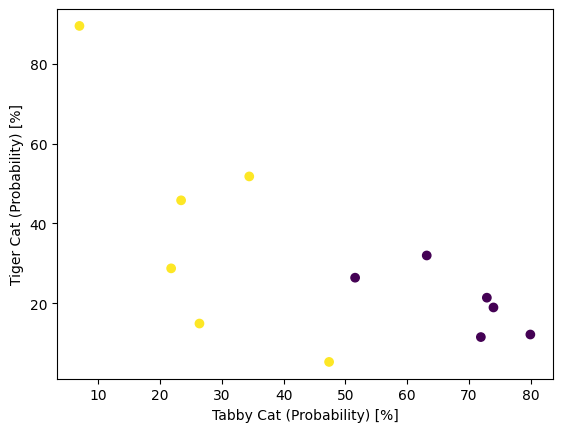

In [49]:
import matplotlib.pyplot as plt
#label 0: Tabby cat, 1: Tiger cat
Data = [[73.96, 18.92], [79.93, 12.14], [71.92, 11.50], [63.16, 31.95], [72.89, 21.37], 
        [51.57, 26.38], [23.41, 45.77], [6.96, 89.48], [34.44, 51.76], [21.80, 28.72],
        [26.38, 14.89], [47.36, 5.27]]
Label = [0,0,0,0,0,0,1,1,1,1,1,1]

x = [d[0] for d in Data]
y = [d[1] for d in Data]

plt.scatter(x, y, c=Label) 
plt.xlabel("Tabby Cat (Probability) [%]")
plt.ylabel("Tiger Cat (Probability) [%]")
plt.show()

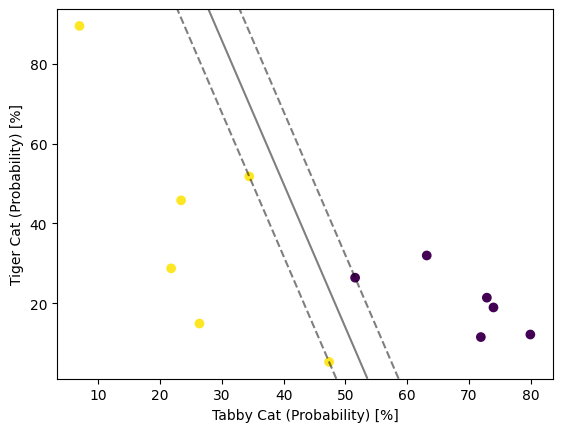

In [50]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import svm

Data = [[73.96, 18.92], [79.93, 12.14], [71.92, 11.50], [63.16, 31.95], [72.89, 21.37], 
        [51.57, 26.38], [23.41, 45.77], [6.96, 89.48], [34.44, 51.76], [21.80, 28.72],
        [26.38, 14.89], [47.36, 5.27]]
Label = [0,0,0,0,0,0,1,1,1,1,1,1]

clf = svm.SVC(kernel='linear')
clf.fit(Data, Label)

x = [d[0] for d in Data]
y = [d[1] for d in Data]
plt.scatter(x, y, c=Label)

ax = plt.gca()
xlim = ax.get_xlim()
ylim = ax.get_ylim()

xx = np.linspace(xlim[0], xlim[1], 100)
yy = np.linspace(ylim[0], ylim[1], 100)
XX, YY = np.meshgrid(xx, yy)
xy = np.vstack([XX.ravel(), YY.ravel()]).T
Z = clf.decision_function(xy).reshape(XX.shape)

ax.contour(XX, YY, Z, colors='k', levels=[-1, 0, 1], alpha=0.5, linestyles=['--', '-', '--'])

plt.xlabel("Tabby Cat (Probability) [%]")
plt.ylabel("Tiger Cat (Probability) [%]")
plt.show()